In [1]:
#Importing the Libraries
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model


In [2]:
TRAIN_DATA_PATH = 'NASA/PC1.csv'

data = pd.read_csv(TRAIN_DATA_PATH)
nameOfHeadersWithLable = data.columns.values

In [3]:
# transform data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
reduced_df = pd.DataFrame(scaled, columns=nameOfHeadersWithLable)
reduced_df.to_csv('FirstlyScaledData.csv')
# display(reduced_df)
# display(scaled)

data2 = pd.read_csv('FirstlyScaledData.csv')
y = data2.Defective
X = data2.drop('Defective', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

nameOfHeaders = X_train.columns.values

In [4]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)


In [5]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 76)                2964      
                                                                 
 batch_normalization (BatchN  (None, 76)               304       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 76)                0         
                                                                 
 dense_1 (Dense)             (None, 38)                2926      
                                                                 
 batch_normalization_1 (Batc  (None, 38)               152       
 hNormalization)                                             

In [7]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,y_test))
# # plot loss
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
37/37 - 2s - loss: 0.2518 - accuracy: 0.0340 - val_loss: 0.5004 - val_accuracy: 0.0000e+00 - 2s/epoch - 51ms/step
Epoch 2/50
37/37 - 0s - loss: 0.0797 - accuracy: 0.0306 - val_loss: 0.2095 - val_accuracy: 0.0068 - 133ms/epoch - 4ms/step
Epoch 3/50
37/37 - 0s - loss: 0.0737 - accuracy: 0.0374 - val_loss: 0.1588 - val_accuracy: 0.0136 - 133ms/epoch - 4ms/step
Epoch 4/50
37/37 - 0s - loss: 0.0716 - accuracy: 0.0391 - val_loss: 0.1379 - val_accuracy: 0.1088 - 133ms/epoch - 4ms/step
Epoch 5/50
37/37 - 0s - loss: 0.0696 - accuracy: 0.0527 - val_loss: 0.1390 - val_accuracy: 0.2585 - 118ms/epoch - 3ms/step
Epoch 6/50
37/37 - 0s - loss: 0.0716 - accuracy: 0.0680 - val_loss: 0.1279 - val_accuracy: 0.1633 - 132ms/epoch - 4ms/step
Epoch 7/50
37/37 - 0s - loss: 0.0686 - accuracy: 0.0578 - val_loss: 0.1248 - val_accuracy: 0.0884 

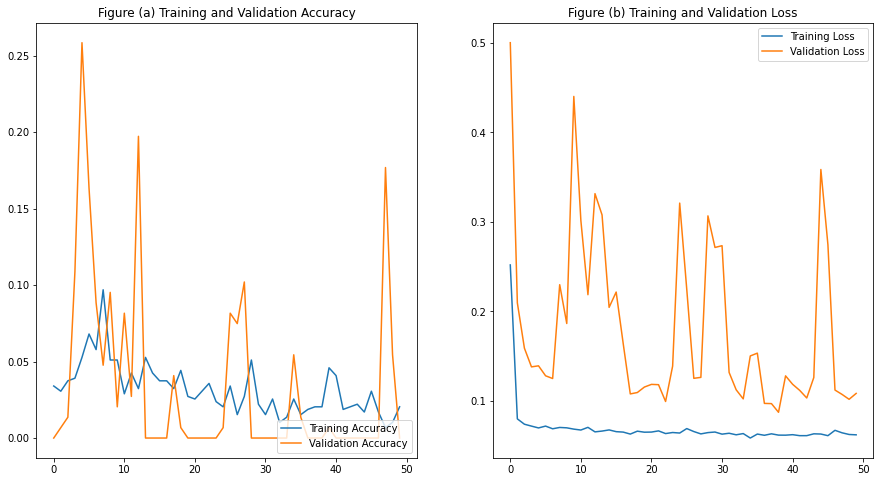

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Figure (a) Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Figure (b) Training and Validation Loss')
plt.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [9]:
#Building a Base Model to compare the performance after compressing the data using Encoder model.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = RandomForestClassifier()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.891156462585034


In [10]:
#Compressing the input data using Encoder Model and fitting it on the Logistic Regression model.
# load the model from file
encoder = load_model('encoder.h5')

encoder.compile(optimizer='adam', loss='mse')

# encode the train data
X_train_encode = encoder.predict(X_train)

# encode the test data
X_test_encode = encoder.predict(X_test)

# nameOfHeaders = X_train.columns.values
# reduced_df = pd.DataFrame(encoder.predict(x_test), columns=nameOfHeaders)

# reduced_df.to_csv('PredictedJM1OnTestData.csv')


# define the model
random_forest = RandomForestClassifier(max_depth=50)
# fit the model on the training set
random_forest.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = random_forest.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

5/5 [==============================] - 0s 2ms/step
0.891156462585034


In [11]:
print('Optimal number of features: {}'.format(random_forest.n_features_))

Optimal number of features: 19


C:\Users\Zbook\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


array([0.04969525, 0.05421858, 0.0404617 , 0.05675197, 0.05099955,
       0.10269908, 0.04345583, 0.03972593, 0.04458244, 0.04875357,
       0.05540587, 0.04557077, 0.04470069, 0.08195821, 0.05933899,
       0.03902635, 0.04204879, 0.03209311, 0.06851335])

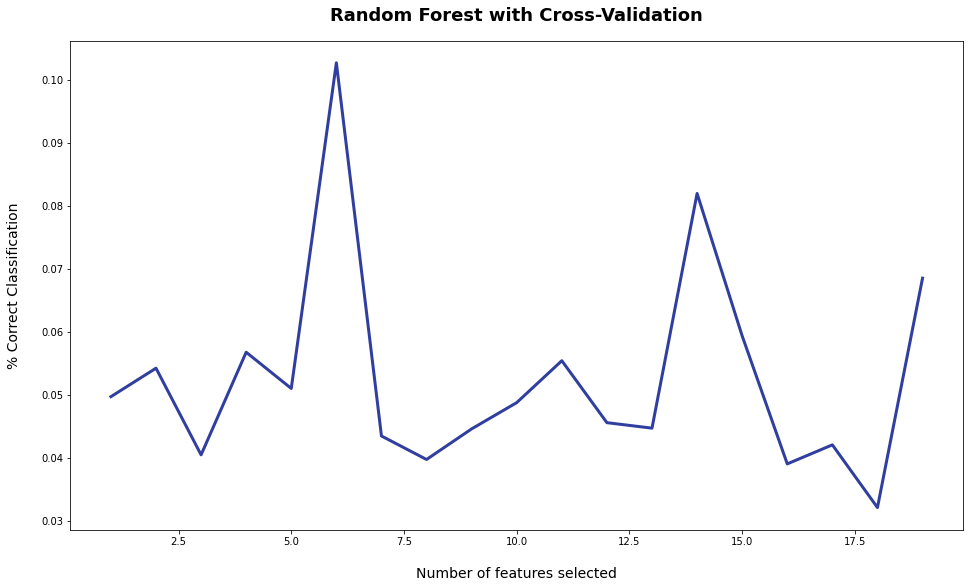

In [12]:
display(random_forest.feature_importances_)
plt.figure(figsize=(16, 9))
plt.title('Random Forest with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(random_forest.feature_importances_) + 1), random_forest.feature_importances_, color='#303F9F', linewidth=3)

plt.show()